# Programming Assignment 2 - Elastic net regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
import itertools
from typing import Tuple
import numpy as np
import pandas as pd

# Import and set up the graphing environment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots legible and focus on trends (not specific values)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine();

<Figure size 432x288 with 0 Axes>

Import our elastic net regression module and the utilities.

In [2]:
import utils
import elastic_net

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the experiments.

In [3]:
import sys
sys.path.append('./test')
import test_all
# Set to true to see each test result
test_all.test_all(False, './data')
print('All tests passed')

All tests passed


Constants used in the experiments.

In [4]:
LAMBDAS_TO_TEST = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
ALPHAS_TO_TEST = [0.0, 1/5, 2/5, 3/5, 4/5, 1.0]
NUM_FOLDS = 5

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [5]:
FEATURE_NAMES = []

def read_dataset(standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    global FEATURE_NAMES
    
    x, y, FEATURE_NAMES = utils.read_dataset('./data/Credit_N400_p9.csv')

    # Encode the categorical values
    utils.encode_binary_cateogry(x, column=6, one_value='Female')  # gender
    utils.encode_binary_cateogry(x, column=7, one_value='Yes')  # student
    utils.encode_binary_cateogry(x, column=8, one_value='Yes')  # married

    if standardize:
        utils.scale(x)
        utils.center(y)

    return x, y

# Deliverable 1 - effect of alpha on coefficients

> _Illustrate the effect of the tuning parameter on the inferred elastic net regression coefficients by generating six plots (one for each α value) of nine lines (one for each of the p = 9 features), with the y-axis as β̂j, j = 1,2, ... ,9, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular β̂j._

A helper plot function.

In [6]:
def plot_betas(betas: np.ndarray, title: str):
    # Create a DataFrame in the long format
    df = pd.DataFrame(np.squeeze(betas), columns=FEATURE_NAMES,
                      index=LAMBDAS_TO_TEST)
    df = df.stack().reset_index()
    df.columns = ['Lambda', 'Feature', 'Standardized Coefficients']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 6));
    sns.lineplot(ax=ax, y='Standardized Coefficients', x='Lambda', data=df,
                 hue='Feature', style='Feature', linewidth=3)
    ax.set_xscale('log')
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.show()

Perform regression with the different alpha and lambda values and plot each alpha (takes several seconds to complete)

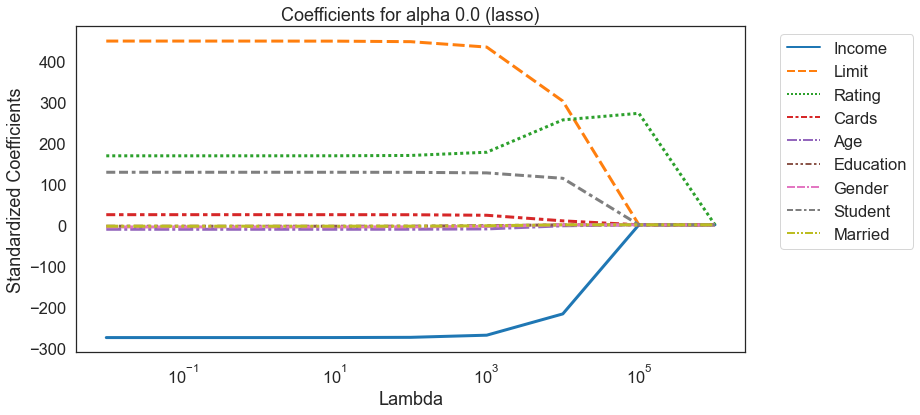

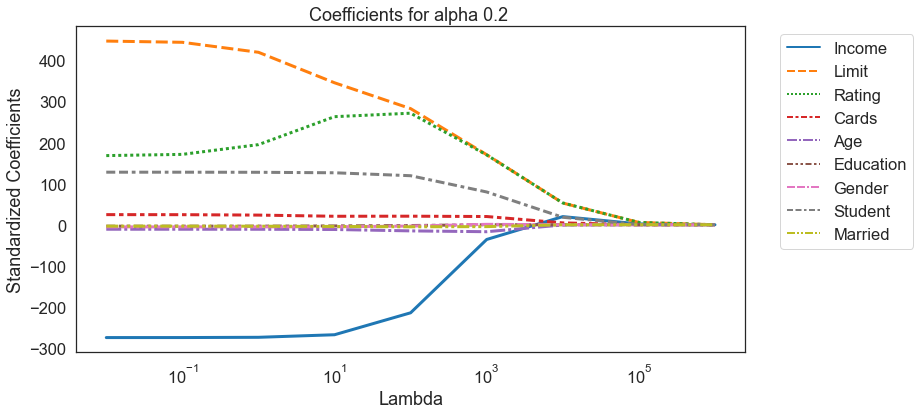

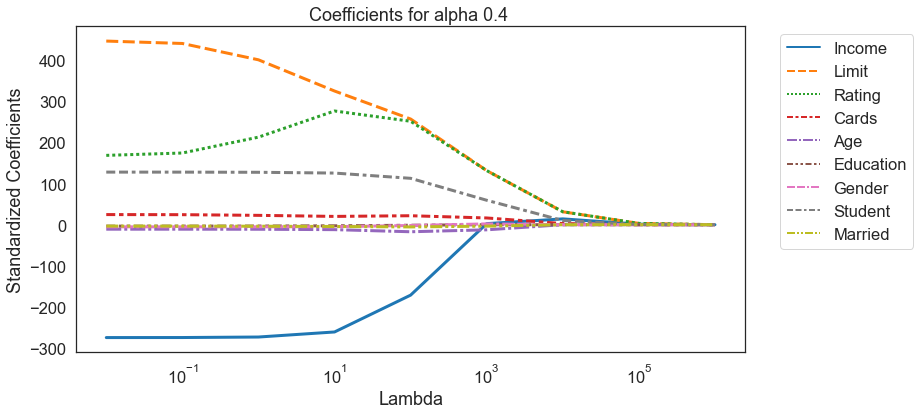

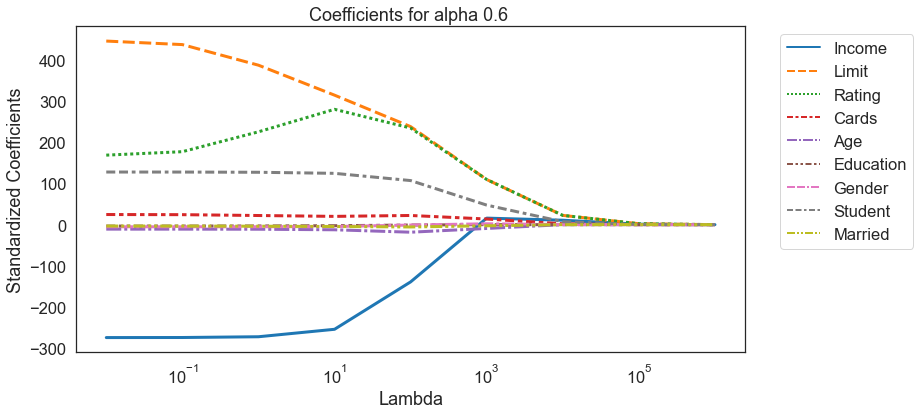

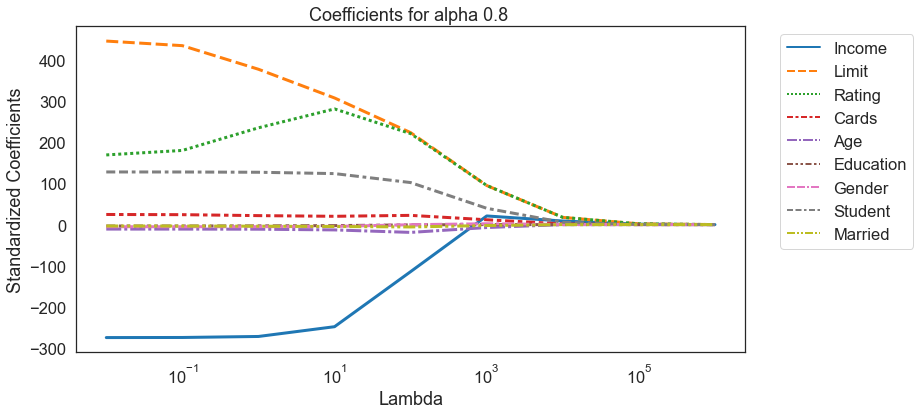

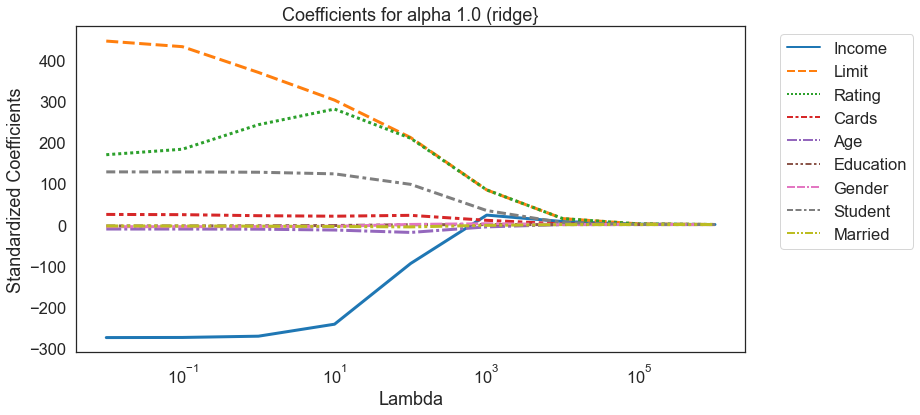

In [7]:
all_betas = []
for alpha in ALPHAS_TO_TEST:
    betas = []
    for lmbda in LAMBDAS_TO_TEST:
        x, y = read_dataset()
        b = elastic_net.fit(x, y, lmbda=lmbda, alpha=alpha, iterations=1_000)
        betas.append(b)
        all_betas.append([alpha, lmbda, b])
    annotation = '(lasso)' if alpha == 0 else '(ridge}' if alpha == 1.0 else ''
    plot_betas(betas, f'Coefficients for alpha {alpha} {annotation}')

# Deliverable 2 - effect of alpha on MSE (with cross validation)

> _Illustrate the effect of the tuning parameters on the cross validation error by generating a plot of six lines (one for each α value) with the y-axis as CV(5) error, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular CV(5) error._

Perform regression with the different lambda values and cross validation (takes several seconds to complete).

In [8]:
mse = []
for (alpha, lmbda) in itertools.product(ALPHAS_TO_TEST, LAMBDAS_TO_TEST):
    x, y = read_dataset(standardize=False)
    fold_mse = np.zeros(NUM_FOLDS)
    for fold in range(1, NUM_FOLDS+1, 1):
        x_train, x_val, y_train, y_val = utils.split_fold(x, y,
                                                          num_folds=NUM_FOLDS,
                                                          fold=fold)
        utils.scale_val(x_train, x_val)
        utils.center_val(y_train, y_val)

        model = elastic_net.fit(x_train, y_train, lmbda=lmbda, alpha=alpha, iterations=1_000)
        predictions = elastic_net.predict(x_val, model)
        fold_mse[fold-1] = utils.mse(y_val, predictions)
    mse.append([alpha, lmbda, fold_mse.mean()])

Plot the results.

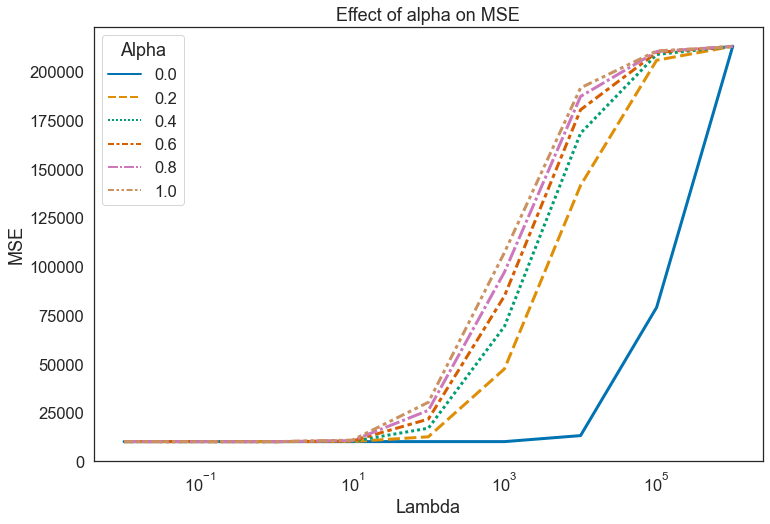

In [9]:
def plot_mse(mse: pd.DataFrame, title: str):
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    # Use dashes and a contrasting palette to make it easier to tell them apart
    sns.lineplot(ax=ax, y='MSE', x='Lambda', hue='Alpha', data=mse,
                 style='Alpha', palette='colorblind', linewidth=3)
    ax.set_xscale('log')
    ax.set_title(title)

mse_df = pd.DataFrame(mse, columns=['Alpha', 'Lambda', 'MSE'])
plot_mse(mse_df, 'Effect of alpha on MSE')

# Deliverable 3 - the alpha/lambda with the smallest MSE

> _Indicate the pair of values λ and α that generated the smallest CV(5) error._

In [10]:
smallest_mse = mse_df.MSE.min()
smallest_mse_record = mse_df[mse_df.MSE == smallest_mse]
smallest_mse_lambda = smallest_mse_record.Lambda.iloc[0]
smallest_mse_alpha = smallest_mse_record.Alpha.iloc[0]
print(f'The smallest MSE is {smallest_mse:.2f}' +
    f' with lambda {smallest_mse_lambda}' +
    f' and alpha {smallest_mse_alpha}')

The smallest MSE is 10073.66 with lambda 1.0 and alpha 0.4


# Deliverable 4 - model parameters for the alpha/lambda with the smallest MSE

> _Given the optimal λ and α pair, retrain your model on the entire dataset of N = 400 observations and provide the estimates of the p = 9 best-fit model parameters. How do these estimates compare to the estimates obtained from ridge regression (α = 1 under optimal λ for α = 1) and lasso (α = 0 under optimal λ for α = 0) on the entire dataset of N = 400 observations?_

Train a model with the alpha and lambda that resulted in the smallest MSE.

In [11]:
x, y = read_dataset()
betas4 = elastic_net.fit(x, y, lmbda=smallest_mse_lambda, alpha=smallest_mse_alpha, iterations=1_000)

Show the coefficients for this model.

In [12]:
for feature, beta in zip(FEATURE_NAMES, betas4.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -273.29
     Limit:  401.17
    Rating:  212.99
     Cards:   22.73
       Age:  -11.08
 Education:   -3.23
    Gender:   -5.16
   Student:  127.51
   Married:   -3.74


Compare this model with the ones calculated for ridge (alpha = 1.0) and lasso (alpha = 0.0), for the same lambda.

In [13]:
# Betas for alpha = 0.0 (lasso) and alpha = 1.0 (ridge)
betas_ridge = [b for b in all_betas if b[1] == smallest_mse_lambda and b[0] == 1.0][0]
betas_lasso = [b for b in all_betas if b[1] == smallest_mse_lambda and b[0] == 0.0][0]
# Combine into on DataFrame, together with the best SME betas
df4 = pd.DataFrame([[betas_lasso[0], betas_lasso[2].flatten()],
                    [smallest_mse_alpha, betas4.flatten()],
                    [betas_ridge[0], betas_ridge[2].flatten()]],
                   columns=['Alpha','Coefficients'])
# Expand the betas into individual feature columns
df4[FEATURE_NAMES] = pd.DataFrame(df4.Coefficients.to_list())
# Dropped the duplicated coefficient columns, now that it was expanded
df4.drop(columns=['Coefficients'], inplace=True)
df4

,Alpha,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married
0,0.0,-274.631854,447.420680,168.015327,24.645286,-10.930332,-3.491113,-5.198826,127.953458,-3.402579
1,0.4,-273.293493,401.170303,212.986221,22.732400,-11.084213,-3.234057,-5.157730,127.512076,-3.735711
2,1.0,-271.231405,369.546631,242.584883,21.492998,-11.270714,-3.045374,-5.094105,127.078410,-3.975377


The table shows that the coefficents for the alpha of the smallest MSE (0.4) holding lambda constant (1.0) is between the lasso coefficient (alpha = 0.0) and the ridge coefficient (alpha = 1.0). This is the expected behavior for such an alpha value of 0.4 (almost halfway between the lasso and ridge alpha values).

A visual representation of the differences.

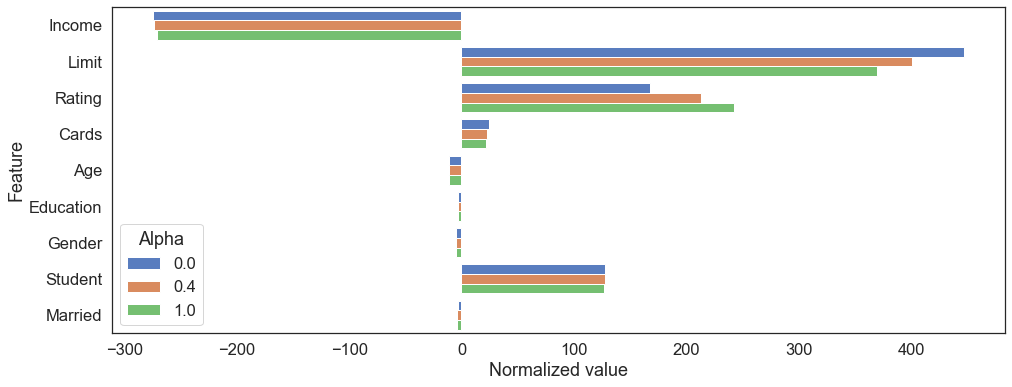

In [14]:
# Long-format dataframe for plotting
df_plot = df4.set_index('Alpha').stack().reset_index()
df_plot.columns = ['Alpha', 'Feature', 'Normalized value']

fig, ax = plt.subplots(figsize=(16, 6));
sns.barplot(ax=ax, x='Normalized value', y='Feature',  data=df_plot,
            hue='Alpha', palette='muted');

# Deliverable 6 - repeat with a machine learning library

> _Implement the assignment using statistical or machine learning libraries in a language of your choice. Compare the results with those obtained above, and provide a discussion as to why you believe your results are different if you found them to be different._

In this section we repeat the experiments above using scikit-learn.

In [15]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

## Deliverable 6.1 - effect of alpha on coefficients

Note that for several combinations of alpha and lambda the scikit-learn algorithm warns that it cannot converge. This is expected in this grid seach, where we trying several values without weeding out combinations that may not make sense for the dataset.

Also note that scikit-learn uses a `l1_ratio` parameter that has the inverse meaning of `alpha`. Thus, we need to use `1-alpha` in this code.

First, disable warnings from scikit-learn for this experiment. In particular, disable the warnings when using alpha = 0 and alpha = 1. Scikit-learn warns that in those cases we should be using the ridgoe or lasso models directly, not elastic net. These are valid warnings for real-life scenarios. In these experiments we are using these values of alpha on purpose.

> UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

> ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation... Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

In [16]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

Fit models for each combination of alpha and lambda values, then show then graph how coefficients (betas) change with lambda.

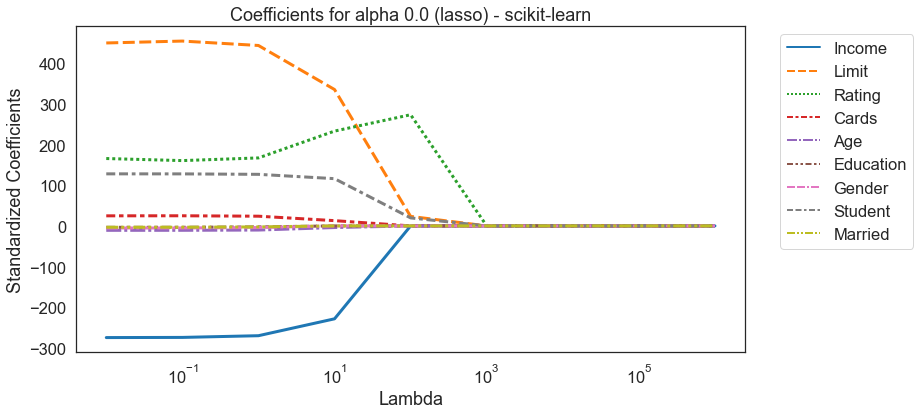

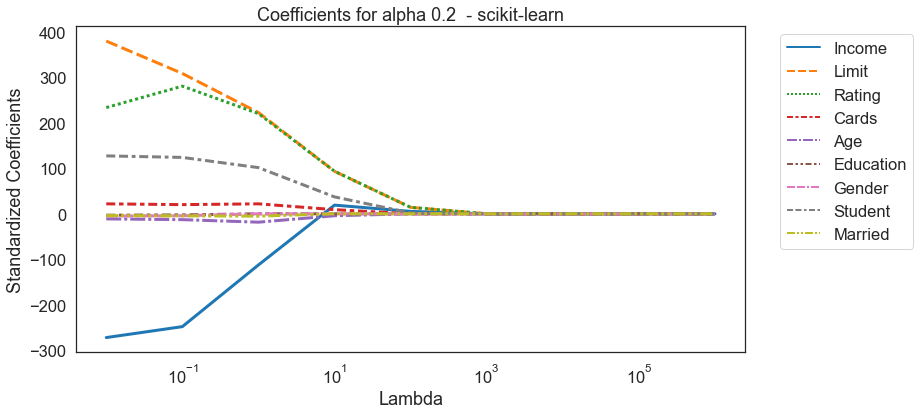

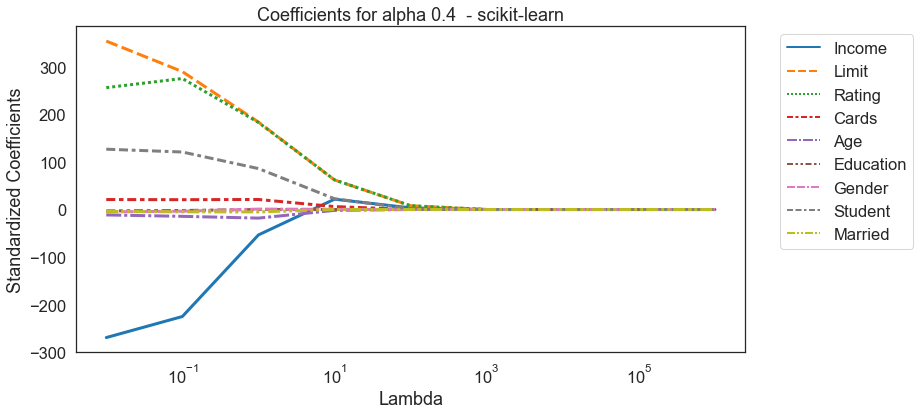

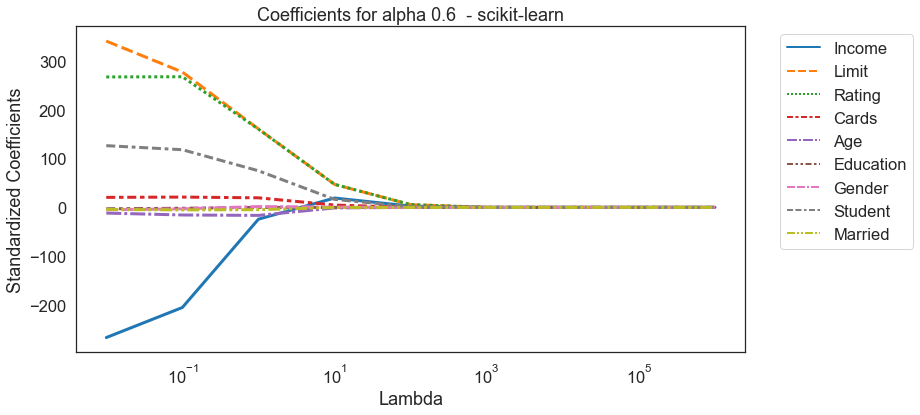

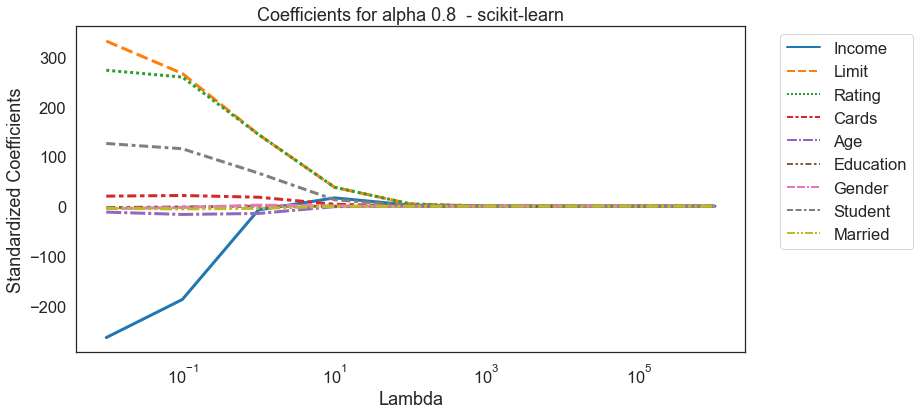

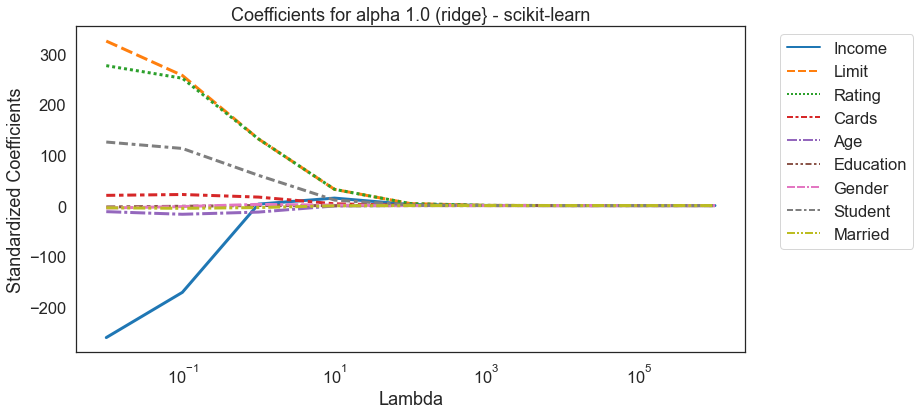

In [17]:
all_betas_sk = []
for alpha in ALPHAS_TO_TEST:
    betas_sk = []
    for lmbda in LAMBDAS_TO_TEST:
        x, y = read_dataset(standardize=False)
        model_sk = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                          linear_model.ElasticNet(alpha=lmbda,
                                                                 l1_ratio=1-alpha))
        model_sk.fit(x, y)
        b = model_sk.named_steps['elasticnet'].coef_.reshape(-1, 1)
        betas_sk.append(b)
        all_betas_sk.append([alpha, lmbda, b])
    annotation = '(lasso)' if alpha == 0 else '(ridge}' if alpha == 1.0 else ''
    plot_betas(betas_sk, f'Coefficients for alpha {alpha} {annotation} - scikit-learn')

## Deliverable 6.2 - effect of alpha on MSE (with cross validation)

Fit one model for each value of alpha and lambda, then get the value of the MSE for each fold and average them.

In [18]:
mse_sk = []
for alpha in ALPHAS_TO_TEST:
    x, y = read_dataset(standardize=False)
    y = y.ravel() # ElasticNetCV wants a 1d vector
    p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.ElasticNetCV(l1_ratio=1-alpha,
                           alphas=LAMBDAS_TO_TEST))
    p.fit(x, y)
    model_sk = p.named_steps['elasticnetcv']
    model_sk.mse_path_.mean(axis=1)
    means_sme_sk = model_sk.mse_path_.mean(axis=1)
    
    # Store the MSE for each lambda
    # The `reversed` part is emprical - the first graph as was reverse from what we
    # got with our code, so reversed the lambdas to match scikit's output
    for i, lmbda in enumerate(reversed(LAMBDAS_TO_TEST)):
        mse_sk.append([alpha, lmbda, means_sme_sk[i]])

Plot the results.

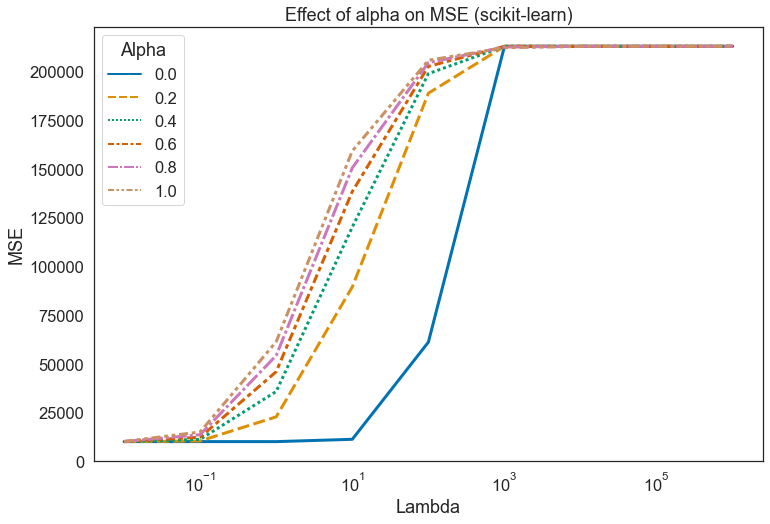

In [19]:
mse_df_sk = pd.DataFrame(mse_sk, columns=['Alpha', 'Lambda', 'MSE'])
plot_mse(mse_df_sk, 'Effect of alpha on MSE (scikit-learn)')

## Deliverable 6.3 - the alpha/lambda with the smallest MSE

In [20]:
smallest_mse_sk = mse_df_sk.MSE.min()
smallest_mse_record_sk = mse_df_sk[mse_df_sk.MSE == smallest_mse_sk]
smallest_mse_lambda_sk = smallest_mse_record_sk.Lambda.iloc[0]
smallest_mse_alpha_sk = smallest_mse_record_sk.Alpha.iloc[0]
print(f'The smallest MSE for scikit-learn is {smallest_mse_sk:.2f}' +
    f' with lambda {smallest_mse_lambda_sk}' +
    f' and alpha {smallest_mse_alpha_sk}')

The smallest MSE for scikit-learn is 10074.22 with lambda 0.01 and alpha 0.2


## Deliverable 6.4 - model parameters for the alpha/lambda with the smallest MSE

Train a model with the alpha and lambda that resulted in the smallest MSE.

In [21]:
x, y = read_dataset()
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                       linear_model.ElasticNet(alpha=smallest_mse_lambda_sk,
                                               l1_ratio=1-smallest_mse_alpha_sk))
p.fit(x, y)
model_sk = p.named_steps['elasticnet']
betas4_sk = model_sk.coef_

Show the coefficients for this model.

In [22]:
for feature, beta in zip(FEATURE_NAMES, betas4_sk.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -271.90
     Limit:  379.44
    Rating:  233.35
     Cards:   21.87
       Age:  -11.20
 Education:   -3.10
    Gender:   -5.11
   Student:  127.21
   Married:   -3.89


Compare this model with the ones calculated for ridge (alpha = 1.0) and lasso (alpha = 0.0), for the same lambda.

In [23]:
# Betas for alpha = 0.0 (lasso) and alpha = 1.0 (ridge)
betas_ridge_sk = [b for b in all_betas_sk if b[1] == smallest_mse_lambda_sk and b[0] == 1.0][0]
betas_lasso_sk = [b for b in all_betas_sk if b[1] == smallest_mse_lambda_sk and b[0] == 0.0][0]
# Combine into on DataFrame, together with the best SME betas
df4_sk = pd.DataFrame([[betas_lasso_sk[0], betas_lasso_sk[2].flatten()],
                       [smallest_mse_alpha_sk, betas4_sk.flatten()],
                       [betas_ridge_sk[0], betas_ridge_sk[2].flatten()]],
                      columns=['Alpha','Coefficients'])
# Expand the betas into individual feature columns
df4_sk[FEATURE_NAMES] = pd.DataFrame(df4_sk.Coefficients.to_list())
# Dropped the duplicated coefficient columns, now that it was expanded
df4_sk.drop(columns=['Coefficients'], inplace=True)
df4_sk

,Alpha,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married
0,0.0,-274.597219,449.777264,165.622792,24.740411,-10.920801,-3.494625,-5.189029,127.957694,-3.378560
1,0.2,-271.898549,379.439151,233.351574,21.871563,-11.203050,-3.097075,-5.106954,127.210261,-3.893156
2,1.0,-261.020365,325.256798,276.663734,20.185906,-12.036197,-2.696035,-4.775034,125.611229,-4.380788


Although the values are different, the table shows the same effect as the one for our regression code: the coefficents for the alpha of the best MSE (0.2) holding lambda constant (0.01) is between the lasso coefficient (alpha = 0.0) and the ridge coefficient (alpha = 1.0). In this case the coefficients are closer to the lasso coefficients because of the smaller alpha (0.2), compared to the alpha found with our regression code (0.4).

## Discussion of differences

Even though the values of alpha and lambda for the smallest SME differ, for all practical purposes we can say that the results are the same for both implementations.

The major difference in behavior can be explained by the function our code minimizes, compared to the one that scikit-learn minimizes. According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), it minimizes this function:

```text
1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
```

Which, using our notation, can be rewritten as

```text
  1
---- ||Y - X*beta||^2 + lambda(1 - alpha)||beta|| + lambda*alpha||beta||^2_2
 2N
 ```

Or, for environments that can render LaTeX: $\frac{1}{2N}\| Y - X\beta \|^2_2 + \lambda(1 - \alpha)\|\beta\|_1 + \lambda\alpha\|\beta\|^2_2$
 
The first term is RSS divided by 1/2N, the second term is the amount of lasso regularization and the third is the amount of ridge regularization. We can see that it is fundamentally the same as the function we optimize in our code, but not exactly the same. The similarities explain why the general shape of the curves in the graphs is the same between the two solutions, but the exact values of alpha and lambda are different. Despite the differences, the coefficients (betas) are in the same range of values, so the models would peform about the same.